# Rebuilding the FRED Macro Dataset and Cleaning It

## Focus Areas

The previously merged dataset from four different macroeconomic indexes at FRED was imbalanced and contained many missing values.

To address this issue, the data retrieval process was started from scratch, with a focus on selecting new metrics as outlined below:

- **Brave-Butters-Kelley Real Gross Domestic Product (BBKMGDP)**: Replacing the previously used Real Gross Domestic Product (GDPC1).
- **Federal Funds Effective Rate**: This metric remains unchanged.
- **Unemployment Rate (UNRATE)**: This metric also remains unchanged.
- **Median Consumer Price Index (MEDCPIM158SFRBCLE)**: Replacing the previously used Inflation, consumer prices for the United States (FPCPITOTLZGUSA).


Fetch Data from Each API URL

In [12]:
import requests
import pandas as pd

# Function to fetch data from the FRED API
def fetch_fred_data(series_id):
    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {
        "series_id": series_id,
        "realtime_start": "2000-01-01",
        "realtime_end": "2024-07-01",  # Updated end date to include 2024
        "api_key": "7bb504adcabc6f374463db2650ad84e5",
        "file_type": "json"
    }

    # Make the API request
    response = requests.get(url, params=params)

    # Check if the request was successful
    if response.status_code == 200:
        data = response.json()
        return data.get('observations', [])
    else:
        print(f"Error fetching {series_id}: {response.status_code} - {response.text}")
        return None

# Define the series IDs
series_ids = ["BBKMGDP", "FEDFUNDS", "UNRATE", "MEDCPIM158SFRBCLE"]

# Fetch data for each series and save to a CSV file
for series_id in series_ids:
    observations = fetch_fred_data(series_id)
    if observations:
        # Convert observations to a DataFrame
        df = pd.DataFrame(observations)
        df = df[['date', 'value']]  # Keep only date and value columns

        # Convert 'date' to datetime to inspect and ensure it's correct
        df['date'] = pd.to_datetime(df['date'])

        # Rename columns
        df.rename(columns={'date': 'Date', 'value': 'Value'}, inplace=True)

        # Save to CSV without any resampling or extra processing
        csv_filename = f"{series_id.lower()}_data.csv"
        df.to_csv(csv_filename, index=False)
        print(f"Data for {series_id} has been saved to {csv_filename}.")

Data for BBKMGDP has been saved to bbkmgdp_data.csv.
Data for FEDFUNDS has been saved to fedfunds_data.csv.
Data for UNRATE has been saved to unrate_data.csv.
Data for MEDCPIM158SFRBCLE has been saved to medcpim158sfrbcle_data.csv.


Merge the Fetched Data

In [32]:
import pandas as pd

# Define the list of CSV filenames
csv_files = ["bbkmGdp_data.csv", "fedfunds_data.csv", "unrate_data.csv", "medcpim158sfrbcle_data.csv"]

# Create a date range covering the required period, e.g., 2000 to 2024
date_range = pd.date_range(start='2010-01-01', end='2024-12-31', freq='M')
merged_df = pd.DataFrame(date_range, columns=['Date'])

# Convert 'Date' to string to match the format in the CSV files
merged_df['Date'] = merged_df['Date'].dt.strftime('%Y-%m-%d')

# Read and merge each CSV file
for csv_file in csv_files:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)

    # Rename the 'Value' column to indicate the source (e.g., 'BBKMGDP_Value')
    series_id = csv_file.split('_')[0].upper()  # Extract series_id from the filename
    df.rename(columns={'Value': f'{series_id}_Value'}, inplace=True)

    # Merge with the main DataFrame on the 'Date' column
    merged_df = pd.merge(merged_df, df, on='Date', how='left')

# Save the merged DataFrame to a new CSV file
merged_df.to_csv('merged_data.csv', index=False)

print("Merged data has been saved to 'merged_data.csv'.")


Merged data has been saved to 'merged_data.csv'.


In [33]:
import pandas as pd

# Define the list of CSV filenames
csv_files = [
    "bbkmGdp_data.csv",      # Brave-Butters-Kelley Real Gross Domestic Product
    "fedfunds_data.csv",     # Federal Funds Effective Rate
    "unrate_data.csv",       # Unemployment Rate
    "medcpim158sfrbcle_data.csv"  # Median Consumer Price Index
]

# Initialize an empty DataFrame for the merged data
merged_df = pd.DataFrame()

# Read and merge each CSV file
for csv_file in csv_files:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)

    # Check if the required columns are present
    if 'Date' not in df.columns or 'Value' not in df.columns:
        print(f"Columns 'Date' and 'Value' are required in {csv_file}.")
        continue

    # Rename the 'Value' column to indicate the source
    series_id = csv_file.split('_')[0].upper()  # Extract series_id from the filename
    df.rename(columns={'Value': f'{series_id}_Value'}, inplace=True)

    # Merge with the main DataFrame on the 'Date' column
    if merged_df.empty:
        # For the first file, initialize the merged_df with this DataFrame
        merged_df = df
    else:
        # Merge on 'Date' with an outer join to keep all dates
        merged_df = pd.merge(merged_df, df, on='Date', how='outer')

# Save the merged DataFrame to a new CSV file
merged_df.to_csv('merged_data.csv', index=False)

print("Merged data has been saved to 'merged_data.csv'.")

Merged data has been saved to 'merged_data.csv'.


# Cleaning the Merged Dataset

The FRED datasets contain a number of duplicates. To clean the merged dataset, I will remove the duplicate rows based on the dates. This process ensures that each date appears only once in the dataset, resulting in a cleaner and more accurate representation of the data.

In [34]:
import pandas as pd

# Load the dataset
df = pd.read_csv('merged_data.csv')

# Display the number of rows before removing duplicates
print(f"Number of rows before removing duplicates: {df.shape[0]}")

# Remove duplicates based on the 'Date' column
df_cleaned = df.drop_duplicates(subset='Date')

# Display the number of rows after removing duplicates
print(f"Number of rows after removing duplicates: {df_cleaned.shape[0]}")

# Save the cleaned DataFrame to a new CSV file
df_cleaned.to_csv('cleaned_FRED_data.csv', index=False)

print("Cleaned data has been saved to 'cleaned_FRED_data.csv'.")

Number of rows before removing duplicates: 1259
Number of rows after removing duplicates: 919
Cleaned data has been saved to 'cleaned_FRED_data.csv'.


In [39]:
import pandas as pd

# Load the cleaned dataset
df_cleaned = pd.read_csv('cleaned_FRED_data.csv')

# Display the original columns
print("Original columns:", df_cleaned.columns.tolist())

# Rename the columns as specified
df_cleaned.rename(columns={
    'BBKMGDP_Value': 'GDP',
    'FEDFUNDS_Value': 'interest_rate',
    'UNRATE_Value': 'unemployment_rate',
    'MEDCPIM158SFRBCLE_Value': 'median_cpi'
}, inplace=True)

# Display the updated columns
print("Updated columns:", df_cleaned.columns.tolist())

# Convert 'Date' column to datetime format
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])

# Filter the dataset for the specified date range
start_date = '2000-01-01'
end_date = '2024-07-01'
df_filtered = df_cleaned[(df_cleaned['Date'] >= start_date) & (df_cleaned['Date'] <= end_date)]

# Save the filtered DataFrame to a new CSV file
df_filtered.to_csv('filtered_FRED_data_2.csv', index=False)

print("Filtered dataset has been saved to 'filtered_FRED_data_2.csv'.")

Original columns: ['Date', 'BBKMGDP_Value', 'FEDFUNDS_Value', 'UNRATE_Value', 'MEDCPIM158SFRBCLE_Value']
Updated columns: ['Date', 'GDP', 'interest_rate', 'unemployment_rate', 'median_cpi']
Filtered dataset has been saved to 'filtered_FRED_data_2.csv'.


# Missing Values

Missing values in each column:
 Date                 0
GDP                  1
interest_rate        1
unemployment_rate    2
median_cpi           0
dtype: int64

Descriptive statistics:
               GDP  interest_rate  unemployment_rate  median_cpi
count  295.000000     295.000000         295.000000  295.000000
mean     2.058761       1.869390           5.726441    2.799734
std      6.866294       2.001429           1.971285    1.382622
min    -69.630993       0.050000           3.400000   -0.286064
25%      0.871813       0.140000           4.200000    2.072088
50%      2.496675       1.160000           5.100000    2.545627
75%      3.820648       3.055000           6.550000    3.198960
max     45.706033       6.540000          14.700000    8.048036


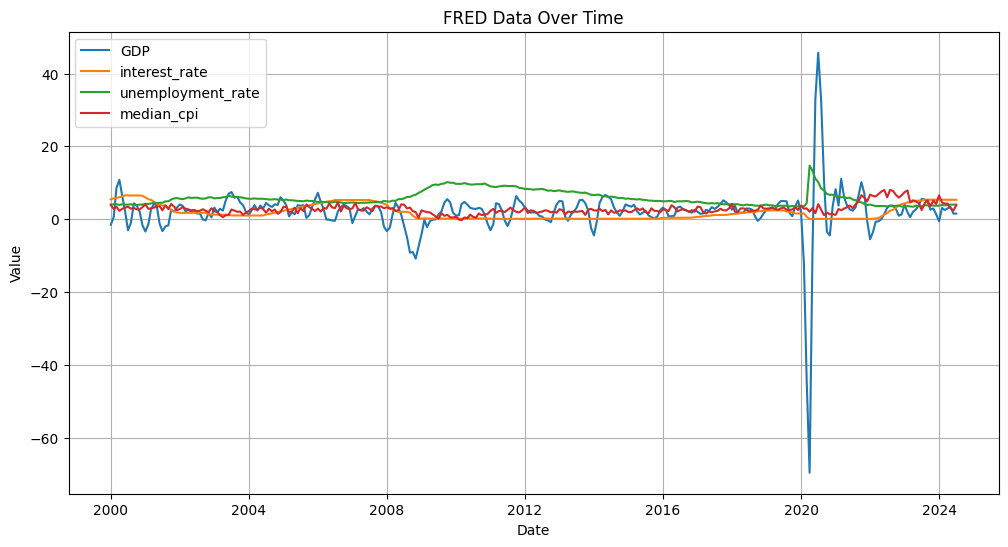


Quarterly Data:
         Date       GDP  interest_rate  unemployment_rate  median_cpi
0 2000-03-31  2.545767       5.676667           4.066667    3.351388
1 2000-06-30  6.407859       6.273333           4.000000    2.757657
2 2000-09-30  0.098528       6.520000           4.000000    3.126933
3 2000-12-31  1.383083       6.473333           3.966667    2.883103
4 2001-03-31 -0.757206       5.593333           4.233333    3.301804

Correlation matrix:
                         GDP  interest_rate  unemployment_rate  median_cpi
GDP                1.000000       0.004311          -0.067359   -0.008495
interest_rate      0.004311       1.000000          -0.585205    0.360584
unemployment_rate -0.067359      -0.585205           1.000000   -0.550255
median_cpi        -0.008495       0.360584          -0.550255    1.000000
Processed data has been saved to 'processed_FRED_data_2.csv'.


In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the renamed dataset
df_cleaned = pd.read_csv('filtered_FRED_data_2.csv')

# Step 2: Check for missing values
missing_values = df_cleaned.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Step 3: Fill missing values (using forward fill as an example)
df_cleaned.fillna(method='ffill', inplace=True)

# Step 4: Convert 'Date' column to datetime format
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])

# Step 5: Generate descriptive statistics
print("\nDescriptive statistics:\n", df_cleaned.describe())

# Step 6: Visualize the data
plt.figure(figsize=(12, 6))
for column in df_cleaned.columns[1:]:  # Exclude 'Date' column
    plt.plot(df_cleaned['Date'], df_cleaned[column], label=column)

plt.title('FRED Data Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

# Step 7: Resample to quarterly data
df_quarterly = df_cleaned.set_index('Date').resample('Q').mean().reset_index()
print("\nQuarterly Data:\n", df_quarterly.head())

# Step 8: Correlation analysis
correlation_matrix = df_cleaned.corr()
print("\nCorrelation matrix:\n", correlation_matrix)

# Step 9: Save the processed dataset
df_cleaned.to_csv('processed_FRED_data_2.csv', index=False)

print("Processed data has been saved to 'processed_FRED_data_2.csv'.")